In [2]:
import h3
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as color
import shapefile as shp
from shapely.ops import unary_union
from shapely.geometry import shape as shape_geom
from shapely.geometry import Point
import time

In [3]:
home_folder = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
seed_point_resolution = 5

# we need to coordinates file to access the corner points - glamf/gphif
model_mask_file = home_folder + 'GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,0,:,:]

In [4]:
geoJSON = {'type': 'Polygon',
               'coordinates': [[[-90, -100], [-90, 20], [90, 20],
                                [90, -100]]]}

hexagons = list(h3.polyfill(geoJSON, seed_point_resolution))
print("number of hexagons in the region with grid resolution 5:", len(hexagons))

centroids = np.array([h3.h3_to_geo(hex) for hex in hexagons])
fullh3_lons = centroids[:, 1]
fullh3_lats = centroids[:, 0]

number of hexagons in the region with grid resolution 5: 669644


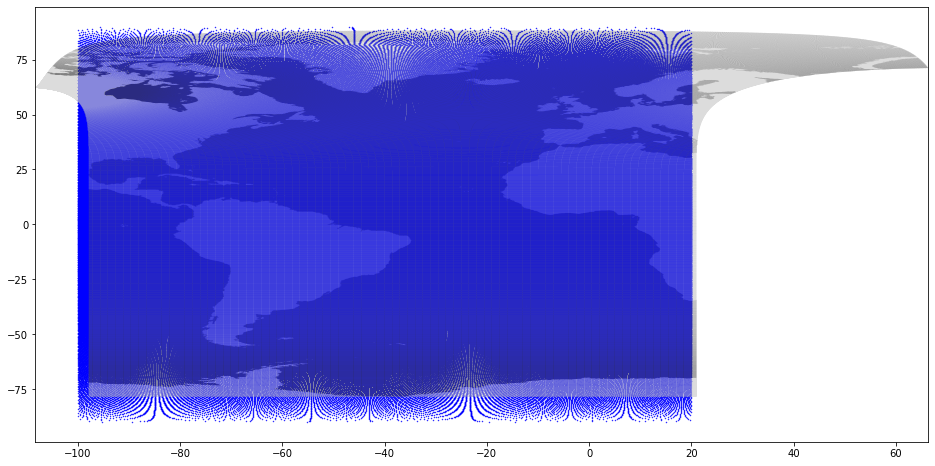

In [8]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes()
colormap = color.ListedColormap(['gainsboro', 'grey'])

ax.scatter(fullh3_lons, fullh3_lats, s=0.2, c='blue')

# remove the first row and first column from the glamf/gphif to access points enclosed in the center
ax.pcolormesh(mask_lon[0], mask_lat[0], mask_land[0, 1:, 1:], cmap=colormap, alpha=0.01)

plt.show()

In [9]:
def get_points_within_polygon(x, y, union):
    # exclude points outside the final polygon
    # numpy ravel(view) is faster than flatten(copy)
    t1 = time.time()
    Points = [Point(x, y) for x, y in zip(x.ravel(), y.ravel())]
    print("Total number of points: ", len(Points))
    Points = unary_union(Points)

    # intersection over within or contains- this one return points(MultiPoint)  that lie within the polygon
    result = Points.intersection(union)
    print("Time to get the points within the outer polygon: ", time.time() - t1)

    print("Points within: ", len(result))
    final_lats = np.array([a.y for a in result])
    final_lons = np.array([a.x for a in result])
    return final_lats, final_lons


In [10]:
# region: Get shape files of Atlantic Ocean, Southern Ocean and Arctic Ocean
data_folder='/storage/shared/oceanparcels/output_data/data_Darshika/TaraC/'
file1 = data_folder + 'iho_Atlantic.zip'
file2 = data_folder + 'iho_Arctic.zip'
file3 = data_folder + 'iho_SO.zip'

# with shp.Reader(file) as sf:
sf1 = shp.Reader(file1)
print(sf1)
sf2 = shp.Reader(file2)
print(sf2)
sf3 = shp.Reader(file3)
print(sf3)

# Only Arctic and Atlantic first
poly_list = sf1.shapes() + sf2.shapes()

# dissolve multiple polygons to get one outer bound
t1 = time.time()
union_atlantic_arctic_shape = unary_union(
    [shape_geom(s.__geo_interface__) for s in poly_list])  # returns shapely type polygon
print("Time to get the outer Polygon: ", time.time() - t1)

# SO separately- to remove points later left of 67W
poly_list = sf3.shapes()
t1 = time.time()
union_southern_shape = unary_union([shape_geom(s.__geo_interface__) for s in poly_list])
print("Time to get the outer Polygon: ", time.time() - t1)

# endregion

shapefile Reader
    17 shapes (type 'POLYGON')
    17 records (11 fields)
shapefile Reader
    16 shapes (type 'POLYGON')
    16 records (11 fields)
shapefile Reader
    1 shapes (type 'POLYGON')
    1 records (11 fields)
Time to get the outer Polygon:  602.2911968231201
Time to get the outer Polygon:  0.02305293083190918


In [12]:
t1 = time.time()
final_AOlats, final_AOlons = get_points_within_polygon(fullh3_lons, fullh3_lats, union_atlantic_arctic_shape)
final_SOlats, final_SOlons = get_points_within_polygon(fullh3_lons, fullh3_lats, union_southern_shape)

# for SO - remove points on the west of 80 deg W
SOlons_index = np.where(final_SOlons >= -67)
SOlats = final_SOlats[SOlons_index]
SOlons = final_SOlons[SOlons_index]
regions_lats = np.concatenate((final_AOlats, SOlats))
regions_lons = np.concatenate((final_AOlons, SOlons))
print('All points: ',len(regions_lats), len(regions_lons))
print("Unique points: ", len(np.unique(regions_lats)), len(np.unique(regions_lons)))
print("Time to get all points ", time.time() - t1)

Total number of points:  669644
Time to get the points within the outer polygon:  9.486946105957031
Points within:  357678


/tmp/ipykernel_182254/3155723632.py:13: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print("Points within: ", len(result))
/tmp/ipykernel_182254/3155723632.py:14: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  final_lats = np.array([a.y for a in result])
/tmp/ipykernel_182254/3155723632.py:15: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  final_lons = np.array([a.x for a in result])


Total number of points:  669644
Time to get the points within the outer polygon:  7.196496963500977
Points within:  29063
All points:  378589 378589
Unique points:  378589 378589
Time to get all points  27.556849718093872


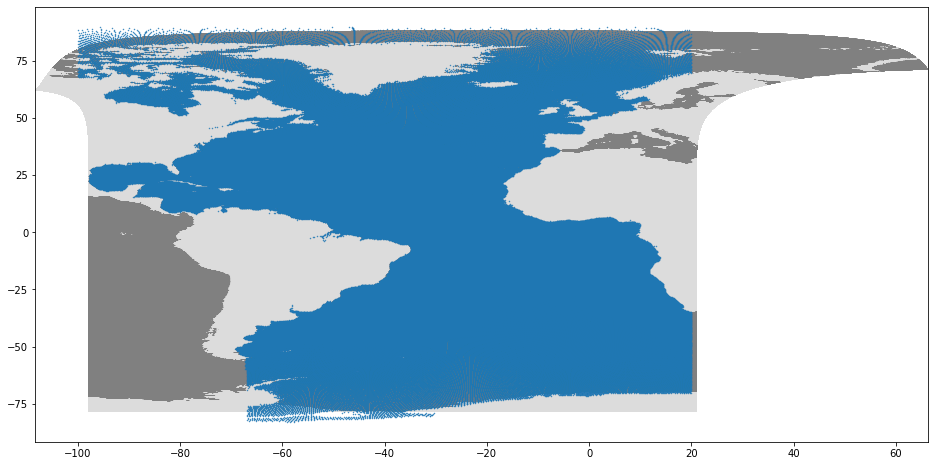

In [13]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes()
colormap = color.ListedColormap(['gainsboro', 'grey'])

# remove the first row and first column from the glamf/gphif to access points enclosed in the center
ax.pcolormesh(mask_lon[0], mask_lat[0], mask_land[0, 1:, 1:], cmap=colormap, alpha=0.5)
ax.scatter(regions_lons, regions_lats, s=0.2)
plt.show()

In [14]:
# From Mikael Kandoorp's: https://github.com/OceanParcels/Global_Analysis_Mikael/blob/main/create_release_uniform_h3.py
land_val_release = griddata((mask_lon.ravel(), mask_lat.ravel()), mask_land.ravel(),
                            (regions_lons, regions_lats), method='linear', fill_value=0)
bool_mask = land_val_release.astype(bool)

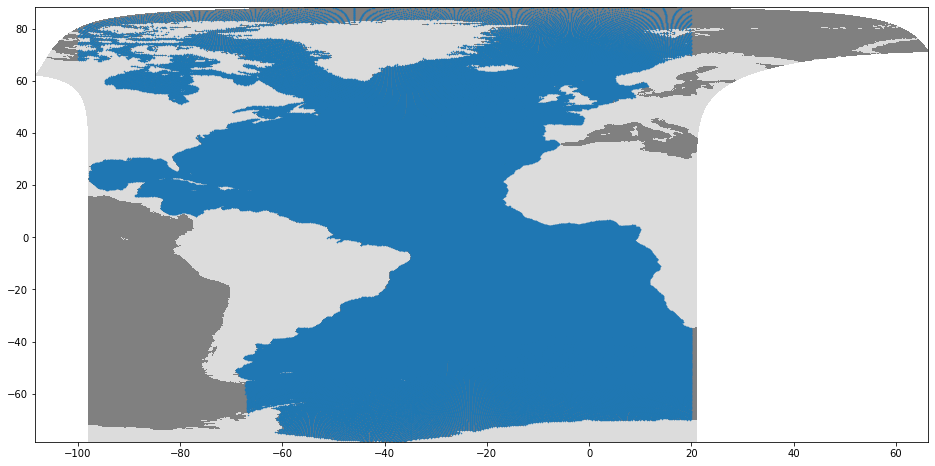

Final number of particles to be saved:  375570 375570


In [15]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes()
colormap = color.ListedColormap(['gainsboro', 'grey'])

# remove the first row and first column from the glamf/gphif to access points enclosed in the center
ax.pcolormesh(mask_lon[0], mask_lat[0], mask_land[0, 1:, 1:], cmap=colormap)


release_lons = regions_lons[bool_mask]
release_lats = regions_lats[bool_mask]

ax.scatter(release_lons, release_lats, s=0.3)

plt.show()
print('Final number of particles to be saved: ', len(release_lons), len(release_lats))

In [16]:
# export the lat-lon for release points to npz
np.savez_compressed('/nethome/manra003/analysis/paper01/H3_Res5_release_points.npz',
                    Longitude=release_lons,
                    Latitude=release_lats)
